## **Introduction**
#### Fullname: Minh-Huy Mai-Duc (Saber)
#### Date: 08/01/2025
#### Email: 23122008@student.hcmus.edu.vn
The following code is my solution to Fellowship.ai on Computer Vision (CV) Challenge: Use a pre-trained ResNet 50 and train on the Flowers dataset.
<br>
This experiment is performed on Kaggle platform with GPU T4 x 2 and took about 14 hours.

## **Code**

### 0. **Download and extract the dataset files**

### 1. **Data exploratory**

Analyzing 102 Category Flower Dataset...


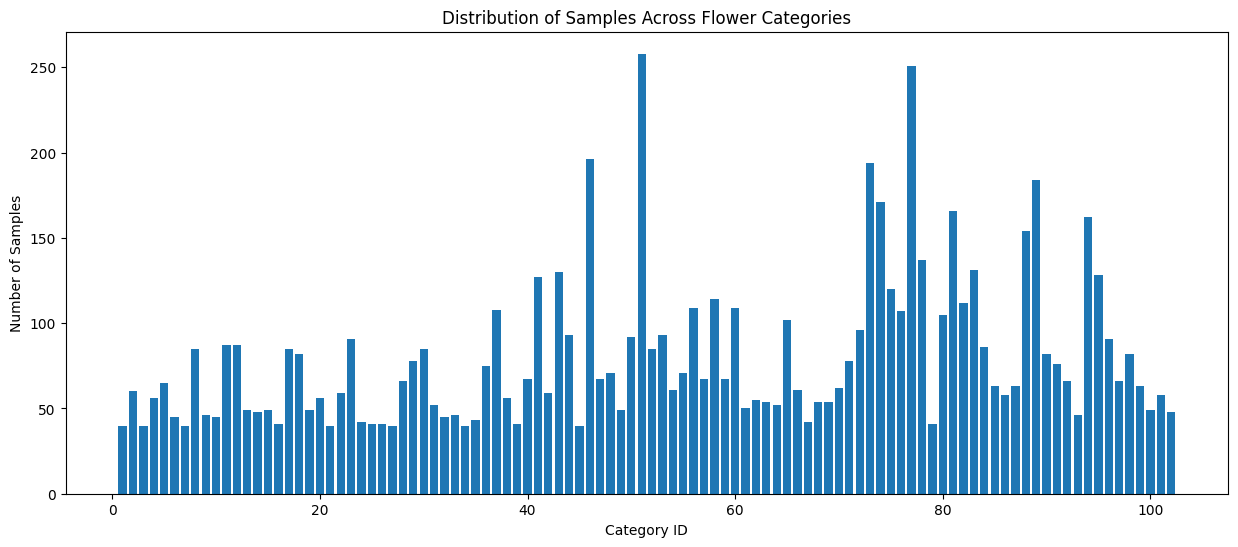

Total number of images: 8189
Number of categories: 102
Average samples per category: 80.28
Min samples in a category: 40
Max samples in a category: 258


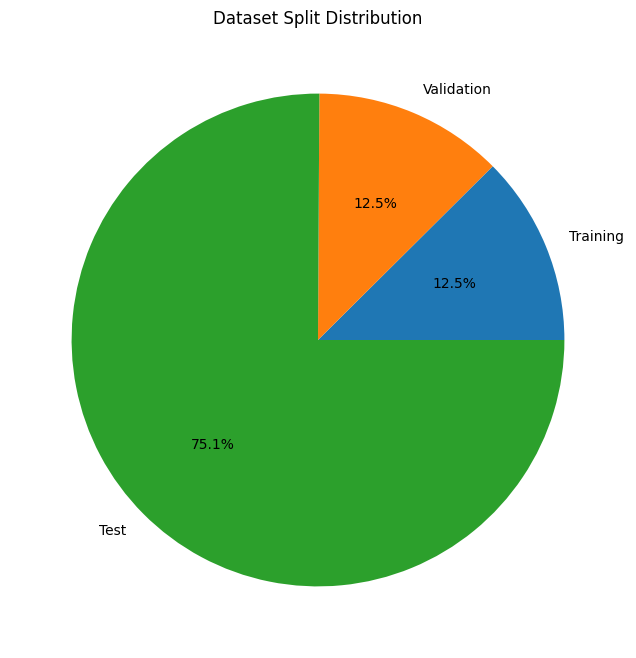

Training set size: 1020 images
Validation set size: 1020 images
Test set size: 6149 images


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


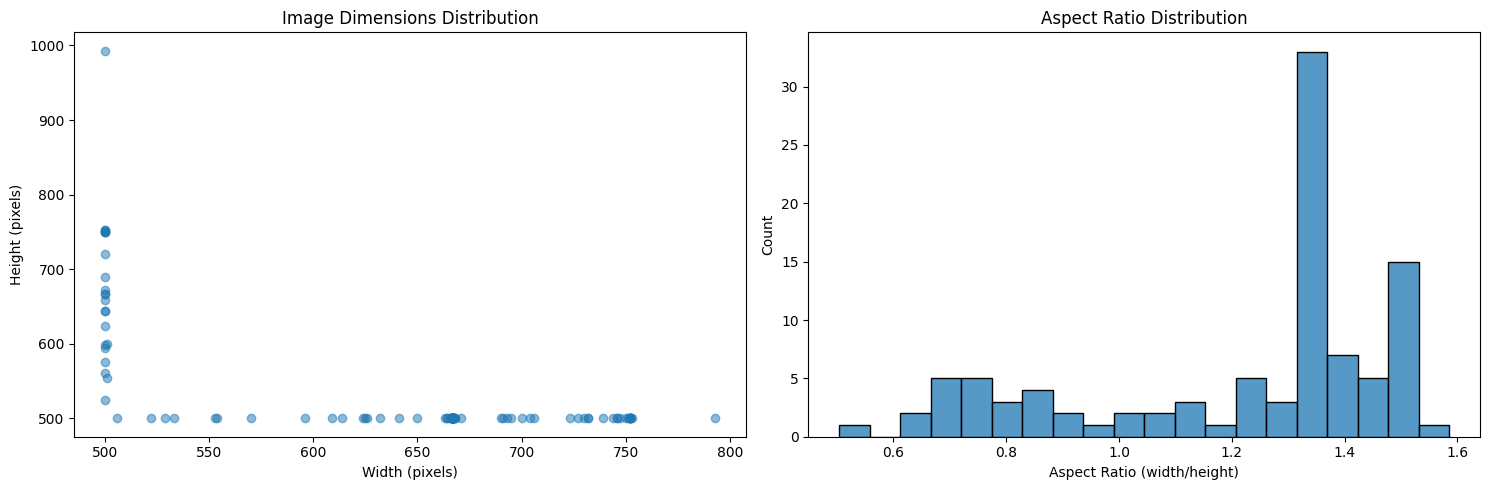

Average image width: 634.42 pixels
Average image height: 540.00 pixels
Average aspect ratio: 1.21


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from PIL import Image
import cv2
from collections import Counter
import glob

def load_dataset_info():
    """Load and process the dataset metadata"""
    # Load the .mat files
    labels = loadmat('imagelabels.mat')
    split_ids = loadmat('setid.mat')
    
    # Extract relevant information
    labels = labels['labels'][0]
    train_ids = split_ids['trnid'][0]
    valid_ids = split_ids['valid'][0]
    test_ids = split_ids['tstid'][0]
    
    return labels, train_ids, valid_ids, test_ids

def analyze_dataset_distribution():
    """Analyze the distribution of flowers across categories"""
    labels, train_ids, valid_ids, test_ids = load_dataset_info()
    
    # Count samples per class
    class_distribution = Counter(labels)
    
    # Create distribution plot
    plt.figure(figsize=(15, 6))
    plt.bar(range(1, len(class_distribution) + 1), 
            [class_distribution[i] for i in range(1, len(class_distribution) + 1)])
    plt.title('Distribution of Samples Across Flower Categories')
    plt.xlabel('Category ID')
    plt.ylabel('Number of Samples')
    plt.show()
    
    # Print statistics
    print(f"Total number of images: {len(labels)}")
    print(f"Number of categories: {len(class_distribution)}")
    print(f"Average samples per category: {np.mean(list(class_distribution.values())):.2f}")
    print(f"Min samples in a category: {min(class_distribution.values())}")
    print(f"Max samples in a category: {max(class_distribution.values())}")

def analyze_data_splits():
    """Analyze the distribution of training, validation, and test sets"""
    labels, train_ids, valid_ids, test_ids = load_dataset_info()
    
    # Calculate split sizes
    splits = {
        'Training': len(train_ids),
        'Validation': len(valid_ids),
        'Test': len(test_ids)
    }
    
    # Create pie chart
    plt.figure(figsize=(10, 8))
    plt.pie(splits.values(), labels=splits.keys(), autopct='%1.1f%%')
    plt.title('Dataset Split Distribution')
    plt.show()
    
    # Print split statistics
    for split_name, split_size in splits.items():
        print(f"{split_name} set size: {split_size} images")

def analyze_image_properties(image_dir='jpg'):
    """Analyze image properties like dimensions and aspect ratios"""
    image_files = glob.glob(os.path.join(image_dir, '*.jpg'))
    widths = []
    heights = []
    aspect_ratios = []
    
    for img_path in image_files[:100]:  # Sample first 100 images for quick analysis
        img = Image.open(img_path)
        width, height = img.size
        widths.append(width)
        heights.append(height)
        aspect_ratios.append(width/height)
    
    # Create subplots for dimensions and aspect ratios
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot dimension distribution
    ax1.scatter(widths, heights, alpha=0.5)
    ax1.set_xlabel('Width (pixels)')
    ax1.set_ylabel('Height (pixels)')
    ax1.set_title('Image Dimensions Distribution')
    
    # Plot aspect ratio distribution
    sns.histplot(aspect_ratios, bins=20, ax=ax2)
    ax2.set_xlabel('Aspect Ratio (width/height)')
    ax2.set_title('Aspect Ratio Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Average image width: {np.mean(widths):.2f} pixels")
    print(f"Average image height: {np.mean(heights):.2f} pixels")
    print(f"Average aspect ratio: {np.mean(aspect_ratios):.2f}")

if __name__ == "__main__":
    print("Analyzing 102 Category Flower Dataset...")
    
    # Run all analyses
    analyze_dataset_distribution()
    analyze_data_splits()
    analyze_image_properties()

##### <p align=center> *Conclusion* </p>
**1. Class Imbalance Issues:**
<br>
- There's significant class imbalance, with samples per category ranging from 40 to 258
- The max-to-min ratio is 6.45:1 (258:40), indicating severe imbalance
- Some categories have over 200 samples while others have just the minimum 40 samples
<br>
=> This imbalance could lead to biased model performance toward majority classes


**2. Data Split Concerns:**
<br>
- The split distribution is highly skewed: 75.1% test, 12.5% validation, and 12.5% training
- This is unusual compared to typical splits (usually 60-80% for training)
- Having only 1020 training images across 102 categories means ~10 images per class for training
<br>
=> This limited training data could make it difficult for models to learn class-specific features

**3. Image Dimension Variations:**
<br>
- Image dimensions show significant variance
- Heights range from approximately 500 to 850 pixels
- Widths range from about 500 to 750 pixels
- The aspect ratio distribution shows two major peaks around 0.8 and 1.4
<br>
=> This variation could complicate batch processing and model architecture design

#### <p align=center> Import libraries </p>

In [4]:
import os
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import scipy.io
from torch.optim import Adam
import random
from typing import Dict, Tuple, List


#### <p align=center> Split dataset </p>
Split with seed = 42, ratio of (train, val, test) = (0.6, 0.2, 0.2)


In [5]:
# Load and organize data
labels = scipy.io.loadmat('imagelabels.mat')['labels'][0]  # Extract labels array (flower categories)

# Create directories for organized data
os.makedirs('flower_data/train', exist_ok=True)
os.makedirs('flower_data/val', exist_ok=True)
os.makedirs('flower_data/test', exist_ok=True)

# Generate all indices (0 to len(labels)-1) and shuffle them
all_indices = np.arange(len(labels))
np.random.seed(42)  # For reproducibility
np.random.shuffle(all_indices)

# Calculate split sizes
total_size = len(all_indices)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)

# Split indices
train_ids = all_indices[:train_size]
val_ids = all_indices[train_size:train_size + val_size]
test_ids = all_indices[train_size + val_size:]

# Keep the same organization function
def organize_data(image_ids, split_name):
    for idx in image_ids:  # Loop through each image index
        label = labels[idx]  # Get the label (class) for the current image
        img_name = f'image_{str(idx + 1).zfill(5)}.jpg'  # Image file naming format in the dataset
        class_folder = f'flower_data/{split_name}/{label}'  # Create folder path based on class label
        os.makedirs(class_folder, exist_ok=True)  # Create the class folder if it doesn't exist
        shutil.move(os.path.join('jpg', img_name), os.path.join(class_folder, img_name))  # Move image to the class folder

# Organize data into train, validation, and test directories
organize_data(train_ids, 'train')
organize_data(val_ids, 'val')
organize_data(test_ids, 'test')

#### <p align=center> [Flowers 1] Data augmentation </p>

In [6]:
def get_augmentation_pipeline(phase: str) -> transforms.Compose:
    """Get augmentation pipeline based on training phase"""
    if phase == "pretrain":
        return transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30),
            transforms.ColorJitter(0.8, 0.8, 0.8, 0.2),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
    elif phase in ["train", "finetune"]:
        return transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation((-30, 30)),
            transforms.ColorJitter(brightness=(0.8, 1.2)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
    else:  # val or test
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])

### 2. <p align=center> [Flowers 1] **Contrastive Learning with Data Augmentation** </p>
This is the proposed pipeline
```text
Pre-trained ResNet-50
      ↓
Phase 1: Self-supervised Pretraining
- Generate positive pairs using strong augmentations
  * Random cropping
  * Color jittering
  * Rotation
  * Cutout
- Train with contrastive loss
      ↓
Phase 2: Supervised Fine-tuning
- Use learned representations
- Class-aware contrastive loss
      ↓
Phase 3: Test-time Augmentation
- Multiple augmented views
- Confidence-weighted prediction
```

#### A. Contrastive Mechanics
Have a deeper look within these papers

1. **SimCLR** (2020): "A Simple Framework for Contrastive Learning of Visual Representations" <br>
by Chen et al. from Google Research
<br>
2. **MoCo** (2020): "Momentum Contrast for Unsupervised Visual Representation Learning" <br>
by He et al. from Facebook AI Research
<br>
3. **BYOL** (2020): "Bootstrap Your Own Latent: A New Approach to Self-Supervised Learning" <br>
by Grill et al. from DeepMind


In [7]:
class ContrastiveTransform:
    """A data augmentation class that creates multiple views of the same image:"""
    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transform(x) for _ in range(self.n_views)]
    
class ContrastiveModel(nn.Module):
    """ResNet50 model modified for contrastive learning"""
    def __init__(self, num_classes: int):
        super().__init__()
        self.encoder = models.resnet50(pretrained=True)
        self.encoder.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x: torch.Tensor, return_features: bool = False):
        """
        Encoder: Modifies final layers to output 128-dimensional features
        Dual purpose:
            Can output feature embeddings (when return_features=True)
            Can perform classification (default mode)
        """
        features = self.encoder(x)
        if return_features:
            return features
        return self.classifier(features)

class NTXentLoss(nn.Module):
    """Normalized Temperature-scaled Cross Entropy Loss"""
    def __init__(self, temperature: float = 0.5):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        n = features.shape[0] // 2
        labels = torch.cat([torch.arange(n) for _ in range(2)])
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(features.device)

        features = F.normalize(features, dim=1)
        similarity_matrix = torch.matmul(features, features.T)
        similarity_matrix = similarity_matrix / self.temperature

        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(features.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(features.device)

        loss = self.criterion(logits, labels)
        loss = loss / (2 * n)
        return loss

#### B. Trainer

In [8]:
class Trainer:
    """
    The Trainer class manages the training, validation, and testing of a neural network model,
    supporting both self-supervised pretraining and supervised training.
    """
    def __init__(self, model: nn.Module, device: torch.device):
        self.model = model
        self.device = device
        self.contrastive_loss = NTXentLoss()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = Adam(model.parameters(), lr=1e-3)
        self.history = {'train_loss': [], 'val_loss': [], 
                       'train_acc': [], 'val_acc': []}

    def pretrain(self, train_loader: DataLoader, epochs: int):
        """Self-supervised pretraining with contrastive loss"""
        self.model.train()
        for epoch in range(epochs):
            running_loss = 0.0
            for batch in train_loader:
                images = torch.cat(batch[0], dim=0).to(self.device)
                self.optimizer.zero_grad()
                features = self.model(images, return_features=True)
                loss = self.contrastive_loss(features)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            print(f'Epoch [{epoch+1}/{epochs}] Pretrain Loss: {running_loss/len(train_loader):.4f}')

    def train_epoch(self, train_loader: DataLoader, val_loader: DataLoader):
        """Training with supervised loss"""
        self.model.train()
        train_loss, train_correct = 0.0, 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        # Validation phase
        self.model.eval()
        val_loss, val_correct = 0.0, 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        # Update history
        self.history['train_loss'].append(train_loss/len(train_loader))
        self.history['val_loss'].append(val_loss/len(val_loader))
        self.history['train_acc'].append(100.*train_correct/total)
        self.history['val_acc'].append(100.*val_correct/total_val)

        return (train_loss/len(train_loader), 100.*train_correct/total,
                val_loss/len(val_loader), 100.*val_correct/total_val)

    def test(self, test_loader: DataLoader) -> Tuple[float, Dict[str, float]]:
        """Evaluate model on test set with TTA"""
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                # Test-time augmentation
                tta_outputs = []
                for _ in range(5):  # 5 different augmented views
                    augmented = transforms.RandomHorizontalFlip()(images)
                    outputs = self.model(augmented)
                    tta_outputs.append(F.softmax(outputs, dim=1))
                
                # Average predictions from all augmented views
                outputs = torch.stack(tta_outputs).mean(0)
                _, predicted = outputs.max(1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        precision = precision_score(all_labels, all_preds, average='weighted')
        sensitivity = recall_score(all_labels, all_preds, average='weighted')
        cm = confusion_matrix(all_labels, all_preds)
        specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))

        metrics = {
            'precision': precision,
            'sensitivity': sensitivity,
            'specificity': specificity
        }
        
        return metrics

    def plot_training_history(self):
        """Plot training and validation metrics"""
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(self.history['train_acc'], label='Train Accuracy')
        plt.plot(self.history['val_acc'], label='Validation Accuracy')
        plt.title('Accuracy History')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

#### <p style="text-align:center"> ***IT'S TIME TO TRAIN THIS BAD BOY*** </p>

In [9]:
# Set device and random seed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

# Create data loaders with appropriate transforms
pretrain_transform = ContrastiveTransform(get_augmentation_pipeline('pretrain'))
train_transform = get_augmentation_pipeline('train')
val_transform = get_augmentation_pipeline('val')

train_dataset = ImageFolder('flower_data/train', transform=train_transform)
val_dataset = ImageFolder('flower_data/val', transform=val_transform)
test_dataset = ImageFolder('flower_data/test', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize model and trainer
model = ContrastiveModel(num_classes=102).to(device)
trainer = Trainer(model, device)

# Phase 1: Self-supervised pretraining
pretrain_loader = DataLoader(
    ImageFolder('flower_data/train', transform=pretrain_transform),
    batch_size=32, shuffle=True
)
trainer.pretrain(pretrain_loader, epochs=10)

# Phase 2: Supervised fine-tuning
print("Starting supervised training...")
for epoch in range(20):
    train_loss, train_acc, val_loss, val_acc = trainer.train_epoch(
        train_loader, val_loader)
    print(f'Epoch [{epoch+1}/20]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

# Save the model
torch.save(model.state_dict(), 'flowers_contrastive_model.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


Epoch [1/10] Pretrain Loss: 3.3985
Epoch [2/10] Pretrain Loss: 2.7591
Epoch [3/10] Pretrain Loss: 2.6322
Epoch [4/10] Pretrain Loss: 2.5683
Epoch [5/10] Pretrain Loss: 2.5365
Epoch [6/10] Pretrain Loss: 2.5059
Epoch [7/10] Pretrain Loss: 2.4853
Epoch [8/10] Pretrain Loss: 2.4731
Epoch [9/10] Pretrain Loss: 2.4712
Epoch [10/10] Pretrain Loss: 2.4513
Starting supervised training...
Epoch [1/20]
Train Loss: 3.8717, Train Acc: 13.09%
Val Loss: 3.8832, Val Acc: 14.91%
Epoch [2/20]
Train Loss: 2.9242, Train Acc: 24.36%
Val Loss: 2.8686, Val Acc: 23.95%
Epoch [3/20]
Train Loss: 2.4934, Train Acc: 31.16%
Val Loss: 2.6347, Val Acc: 32.25%
Epoch [4/20]
Train Loss: 2.1790, Train Acc: 38.51%
Val Loss: 2.2341, Val Acc: 39.52%
Epoch [5/20]
Train Loss: 1.9372, Train Acc: 44.23%
Val Loss: 2.4028, Val Acc: 36.53%
Epoch [6/20]
Train Loss: 1.7446, Train Acc: 49.11%
Val Loss: 1.9299, Val Acc: 45.51%
Epoch [7/20]
Train Loss: 1.5817, Train Acc: 53.37%
Val Loss: 1.7984, Val Acc: 51.01%
Epoch [8/20]
Train Los

### 3. **Empirical result**


#### A. Train vs Validation Accuracy/ Loss

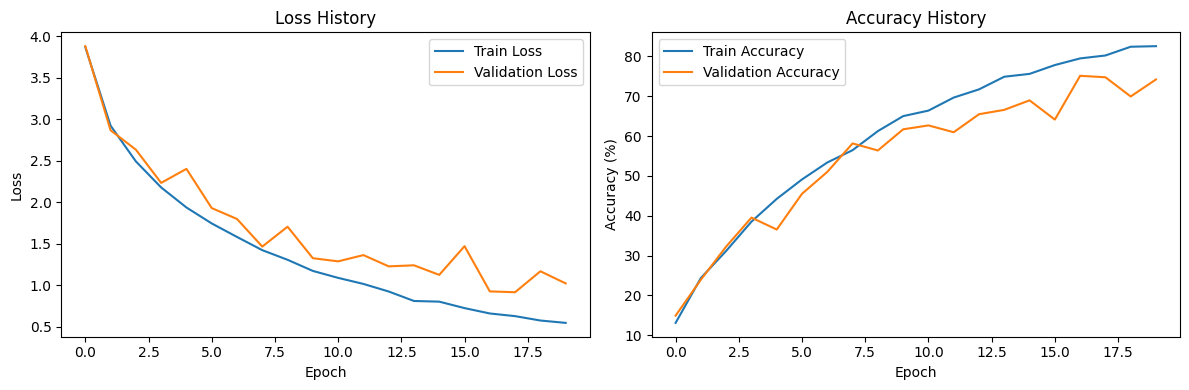

In [10]:
# Plot training history
trainer.plot_training_history()

#### B. Precision, specificity, sensitivity on test result

In [11]:
# Phase 3: Evaluation with test-time augmentation
test_metrics = trainer.test(test_loader)
print("\nTest Results:")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Sensitivity: {test_metrics['sensitivity']:.4f}")
print(f"Specificity: {test_metrics['specificity']:.4f}")


Test Results:
Precision: 0.7881
Sensitivity: 0.7480
Specificity: 0.7346


### 4. **Inference demo**

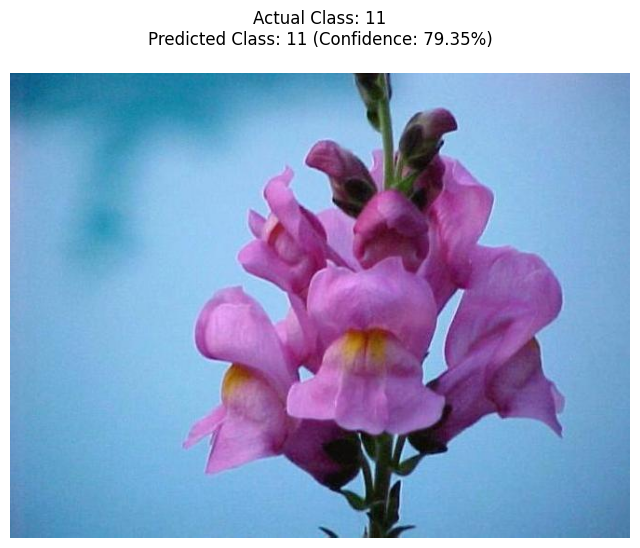


Top 3 Predictions:
Class 11: 79.35%
Class 4: 16.58%
Class 43: 1.13%


In [24]:
def show_image_with_prediction(img_path: str, model: nn.Module, device: torch.device, class_to_idx: dict):
    """Show image and perform inference with proper class labels"""
    # Create reverse mapping from index to original class label
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    # Show the image
    image = Image.open(img_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    
    # Get actual class from path
    actual_class = img_path.split('/')[-2]
    
    # Perform inference
    model.eval()
    transform = get_augmentation_pipeline('test')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)
        predicted_idx = torch.argmax(probabilities).item()
        confidence = probabilities[0][predicted_idx].item()
        
        # Get top 3 predictions
        top3_prob, top3_idx = torch.topk(probabilities, 3)
        top3_prob = top3_prob[0].cpu().numpy()
        top3_idx = top3_idx[0].cpu().numpy()
    
    # Get original class labels
    predicted_class = idx_to_class[predicted_idx]
    top3_classes = [idx_to_class[idx] for idx in top3_idx]
    
    # Display results
    plt.title(f'Actual Class: {actual_class}\nPredicted Class: {predicted_class} (Confidence: {confidence:.2%})', 
              pad=20)
    plt.show()
    
    print("\nTop 3 Predictions:")
    for cls, prob in zip(top3_classes, top3_prob):
        print(f"Class {cls}: {prob:.2%}")
    
    return predicted_class, confidence, actual_class

# Usage example:
model_path = '/kaggle/working/flowers_contrastive_model.pth'
img_path = '/kaggle/working/flower_data/test/11/image_03125.jpg'

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
infer_model = ContrastiveModel(num_classes=102).to(device)
infer_model.load_state_dict(torch.load(model_path, weights_only=True))

# Create dataset just to get class mapping
train_dataset = ImageFolder('/kaggle/working/flower_data/train', transform=None)

# Perform inference with visualization
pred_class, conf, actual_class = show_image_with_prediction(
    img_path, infer_model, device, train_dataset.class_to_idx
)